# HRTEM simulations

In [1]:
from ase.cluster.cubic import FaceCenteredCubic
import numpy as np
import matplotlib.pyplot as plt

from abtem.plot import plot_atoms, plot_ctf
from abtem.potentials import Potential
from abtem.waves import PlaneWaves
from abtem.transfer import CTF
from abtem.utils import scherzer_defocus
from abtem.noise import add_poisson_noise
from abtem.temperature import TDS

In this lesson, you will learn how to simulate a HRTEM image of a nanoparticle. If you wish, you can chose another structure based on what you learned in lesson 1.

## Creating a nanoparticle
ASE has modules for creating [nanoparticles](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html) with a given crystal structure by specifying either the number of layers in different directions, or by making a Wulff construction. Here we create a nanoparticle of gold in the FCC crystal structure, by specifying 6 layers in the (100) directions, 9 in the (110) directions and 5 in the (111) directions. The nanoparticle is first rotated into the (110) zone-axis, then it is rotated such that a (111) plane aligns with the $y$-axis. This is a commonly imaged direction for gold nanoparticles.

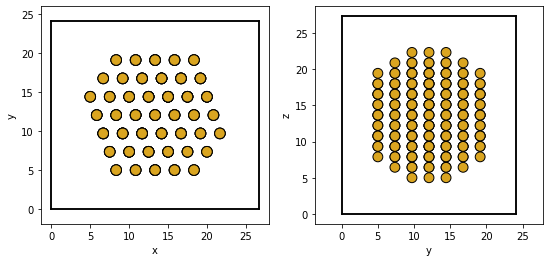

In [2]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [4, 7, 3]
atoms = FaceCenteredCubic('Au', surfaces, layers)
atoms.rotate(np.pi / 4. / np.pi * 180, 'y')
atoms.rotate(np.arctan(np.sqrt(2.)) / np.pi * 180, 'z')
atoms.center(vacuum = 5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
plot_atoms(atoms, ax=ax1)
plot_atoms(atoms, ax=ax2, plane='yz')

## The Potential
As discussed in lesson 2 the electrostatic potential have to be sliced for the multislice algorithm. There are two different levels of approximation available: The full 3d treatment where the potential is sliced, as if it was cut from the actual 3d potential. A less accurate treamtment where each atom is assigned to a slice, and the potential for the atoms in each slice is calculated as if it is infinitely thick.

Below we create a potential using Lobato's parametrization. We also show a slice of the potential.

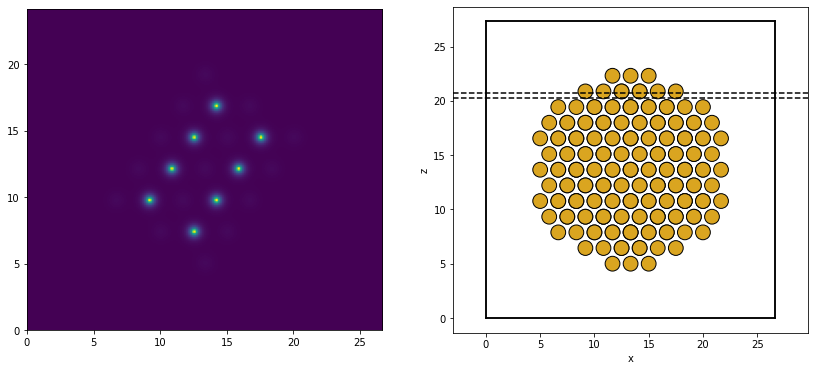

In [4]:
slice_idx = 40

potential = Potential(atoms, sampling=.05, parametrization='lobato', slice_thickness=.5)

slice_array = potential.get_slice(slice_idx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.imshow(slice_array.T, extent = [0, potential.extent[0], 0, potential.extent[1]], origin='lower')

plot_atoms(atoms, ax=ax2, plane='xz')
ax2.axhline(potential.slice_entrance(slice_idx), linestyle='--', color='k')
ax2.axhline(potential.slice_exit(slice_idx), linestyle='--', color='k')

## The planewave multislice algorithm
When simulating HRTEM images it is almost always assumed that the incident wavefunction is a pure plane wave. The angular distribution is generally insignificant across the thickness of a thin specimen.

In [5]:
waves = PlaneWaves(sampling = .05, energy = 300e3)

waves = waves.multislice(potential)

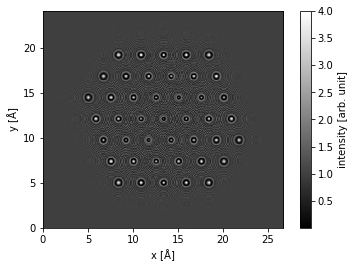

In [6]:
image = waves.get_image(convert='intensity')

plt.imshow(image.array.T, extent=[0, image.extent[0], 0, image.extent[1]], cmap='gray', origin='lower')
plt.colorbar(label='intensity [arb. unit]')
plt.xlabel('x [Å]')
plt.ylabel('y [Å]');

## Phase aberrations

Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice aberrations cause the wave to deviate from a spherical surface. This deviation can be represented as a phase error, $\chi(k, \phi)$ of the spatial frequency in polar coordinates. The phase error can be written a series expansion

$$ 
    \chi(\alpha, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] 
$$

If the microscope is well aligned then off-axis aberrations (astigmatisms) are small and the phase error is dominated by the first two isotropic terms

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) 
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

The `CTF` object takes parameters of the form `Cnm` and `phinm`, and may also be given using their common alias e.g. `defocus = -C10`. Lastly, abTEM includes a utility for converting from the cartesian to polar expansion coefficients.

We can use the function `plot_ctf` to preview the CTF along a radial.


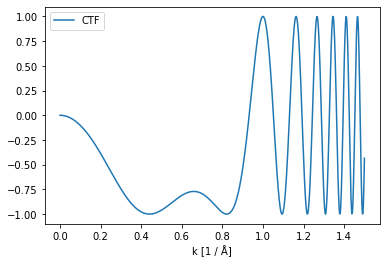

In [7]:
Cs = 1e-4 * 1e10
defocus = scherzer_defocus(Cs, energy=300e3)
ctf = CTF(defocus=defocus, Cs = Cs, energy=300e3)

plot_ctf(ctf, max_k=1.5)

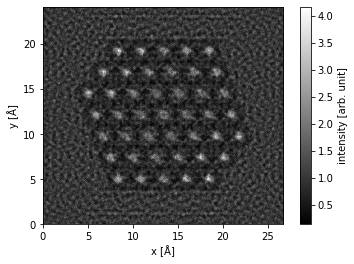

In [8]:
new_waves = waves.apply_ctf(ctf)
image = new_waves.get_image()

plt.imshow(image.array.T, extent=[0, image.extent[0], 0, image.extent[1]], cmap='gray', origin='lower')
plt.colorbar(label = 'intensity [arb. unit]')
plt.xlabel('x [Å]')
plt.ylabel('y [Å]');

## Partial coherence
The aperture function cuts off beams scattered above a certain critical angle, thus effectively limiting the attainable resolution. However it is the partial coherence envelope function $E(k)$ which usually dampens the signal of beams scattered at high angles, and imposes a maximum to the transmitted spatial frequency. In abTEM the envlope function is constructed as a product of three envelopes

$$
    E(k) = E_s(k) E_t(k) E_d(k)
$$

### Partial spatial coherence
As the electron source has a finite size, the incident beam contains a distribution of incident directions. In HRTEM this is quantified by the angular spread. Assume that each incident direction performs its own experiment and that thedistribution of incident directions is small, then it can be shown that it can be modelled the spatial coherence envelope function, is given by

$$
    E_s(k) = \exp\left(-\frac{\beta}{4\lambda^2}\left| \frac{\partial \chi(k)}{\partial k}\right|^2  \right) .
$$

where $\beta$ is the $1/e$ width of the distribution of angles. The parameter $\beta$ is equivalent to the `angular_spread` property of the `CTF` object.

### Partial temporal coherence
A small spread in energy, $\Delta E$, of the incident electrons is equivalent to a small spread in defocus, due to the chromatic aberration of the objective lens. Fluctuations in the focusing currents, $\Delta I$, of the objective lens also produce an incoherent spread in defocus. Combining these effects, the $1/e$ width of the distribution of defocus values (the focal spread) can be written

$$
    \delta = C_c \sqrt{4 \left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}
$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source. Assuming that $\delta$ is small, it can be shown that focal spread can be approximated as

$$
    E_t(k) = \exp\left[-\frac{1}{2} \left(\pi \lambda \delta \right)^2 k^4 \right] .
$$

The parameter $\delta$ is equivalent to the `focal_spread` property of the `CTF` object.

### Deflections and vibrations
Blurring can also be caused by all kinds of noise leading to a random deflection of the image relative to the detector, such as vibrations, drift of the stage, and magnetic noise fields resulting from eddy currents in the material of the lenses. Assuming that the image deflection is small and follows a Gaussian distribution, this can be included as an additional envelope

$$
	E_d(k) = \exp\left(- \frac{\sigma^2 k^2 \lambda^2}{2}\right) ,
$$

where $\sigma$ is the $1/e$ width of the deflection. The parameter $\sigma$ is equivalent to the `blur` property of the `CTF` object.

Below we create a `CTF` object with all the sources of partial coeherence. In practice it is difficult to know the instrument well enough to estimate the parameters influencing partial coherence, however it is usually dominated by partial temporal coherence.

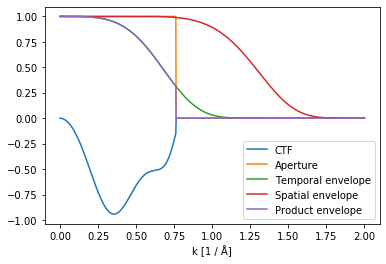

In [9]:
Cs = 2e6
defocus = scherzer_defocus(Cs, energy=300e3)
ctf = CTF(defocus=defocus, Cs=Cs, energy=300e3)

ctf.focal_spread = 60
ctf.angular_spread = .2e-3
ctf.blur = 2
ctf.cutoff = .015

plot_ctf(ctf, max_k=2)

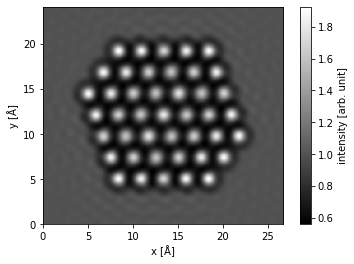

In [10]:
new_waves = waves.apply_ctf(ctf)
image = new_waves.get_image()

plt.imshow(image.array.T, extent=[0, image.extent[0], 0, image.extent[1]], cmap='gray', origin='lower')
plt.colorbar(label = 'intensity [arb. unit]')
plt.xlabel('x [Å]')
plt.ylabel('y [Å]');

Usually defocus is not know very well, hence frequently a defocus series is calculated for comparison to experiment.

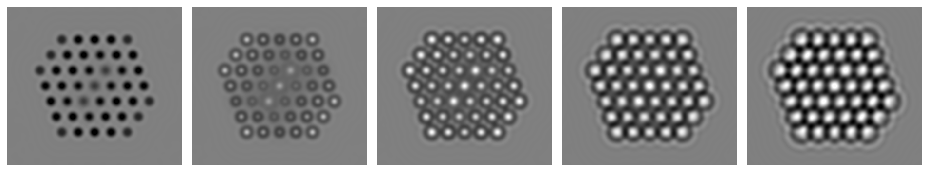

In [11]:
fig, axes = plt.subplots(1,5,figsize=(13,4))

for i in range(5):

    new_waves = waves.apply_ctf(defocus=i*40, Cs=1e4, focal_spread=60)
    image = new_waves.get_image()
    axes[i].imshow(image.array.T, extent=[0, image.extent[0], 0, image.extent[1]], vmin=.5, vmax=1.5, 
                   cmap='gray', origin='lower')
    axes[i].axis('off')

plt.tight_layout()

## Dose
For certain applications, such as benchmarking of analysis methods it is useful to add a realistic level of noise. We assume that the noise is dominated by shot noise, and hence the measured electron count in each pixel can be modelled by a Poisson distribution.

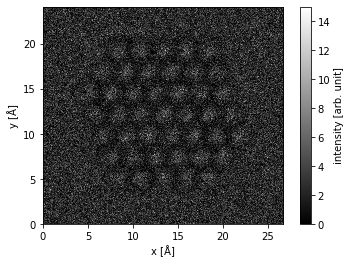

In [12]:
noisy_image = add_poisson_noise(image, dose=1e3)

plt.imshow(noisy_image.array.T, extent=[0, image.extent[0], 0, image.extent[1]], cmap='gray', origin='lower')
plt.colorbar(label = 'intensity [arb. unit]')
plt.xlabel('x [Å]')
plt.ylabel('y [Å]');

## Frozen phonons
The effect of finite temperature is included using the frozen phonon approximation. This is a semi-classical model based on the assumption that a single high-energy electron passing through the specimen at about half the speed of light can only probe a single frozen “snapshot” of the vibrating crystal. The image is produced by averaging incoherently over many snapshots where the atoms are slightly displaced from their equilibrium positions. The frozen phonon model has been shown to be numerically equivalent to the full quantum-mechanical treatment of the inelastic phonon scattering process. The snapshots are typically determined using the Einstein approximation.

The `TDS` object can be used to generate displaced atomic configurations in the Einstein approximation. The incoherent summation is currently a bit of a DIY situation as demonstrated below.

In [13]:
from tqdm.auto import tqdm

tds = TDS(atoms, {'Au':.5}, n=30)

try:
    del tds_image
except NameError:
    pass

for displaced in tqdm(tds.generate(), total=tds.n):
    waves = PlaneWaves(sampling = .05, energy = 300e3)
    waves = waves.multislice(displaced, show_progress=False)
    
    new_waves = waves.apply_ctf(defocus=120, Cs=1e4, focal_spread=60)
    new_image = new_waves.get_image()
    
    try:
        tds_image.array[:] += new_waves.get_image().array
    
    except NameError:
        tds_image = new_waves.get_image()

tds_image.array[:] = tds_image.array[:] / tds.n

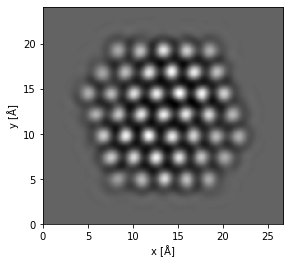

In [14]:
plt.imshow(tds_image.array.T, extent=[0, tds_image.extent[0], 0, tds_image.extent[1]], cmap='gray', origin='lower')
plt.xlabel('x [Å]')
plt.ylabel('y [Å]');